
# Modeling Stock Market Sentiment with ULMFiT

In this tutorial, we will fine-tune a ULMFiT model to predict the stock market sentiment based on a comment about the market. 


## Setup

First we import the necesary libraries for our modeling.


In [0]:
# Install PyTorch 1.0 that works with Colab
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

    100% |████████████████████████████████| 532.5MB 32kB/s 
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2


In [0]:
# import necesary libaries, classes and functions

import pandas as pd
import numpy as np
from fastai.text.data import TextLMDataBunch, TextClasDataBunch
from fastai.text.learner import language_model_learner, text_classifier_learner
from fastai.text.models import AWD_LSTM
from sklearn.model_selection import train_test_split

## Processing Data

We will train the model using messages tagged with SPY, the S&P 500 index fund, from StockTwits.com. StockTwits is a social media network for traders and investors to share their views about the stock market. When a user posts a message, they tag the relevant stock ticker ($SPY in our case) and have the option to tag the messages with their sentiment – “bullish” if they believe the stock will go up and “bearish” if they believe the stock will go down.

Our dataset consists of approximately 100,000 messages posted in 2017 that are tagged with $SPY where the user indicated their sentiment. Before we get to our LSTM Network we have to perform some processing on our data to get it ready for modeling.


#### Read and View Data

First we simply read in our data using pandas, pull out our message and sentiment data into numpy arrays. Let's also take a look at a few samples to get familiar with the data set.

In [0]:
# read our data directly from github

data_url = 'https://github.com/GarrettHoffman/AI_Conf_2019_DL_4_NLP/blob/master/data/StockTwits_SPY_Sentiment_2017.gz?raw=true'
data = df = pd.read_csv(data_url,
                        encoding="utf-8",
                        compression='gzip', 
                        index_col=0)

# get messages and sentiment labels
messages = data.message.values
labels = data.sentiment.values

# View sample of messages with sentiment

for i in range(10):
    print("Messages: {}...".format(messages[i]),
          "Sentiment: {}".format(labels[i]))

Messages: $SPY crazy day so far!... Sentiment: bearish
Messages: $SPY Will make a new ATH this week. Watch it!... Sentiment: bullish
Messages: $SPY $DJIA white elephant in room is $AAPL. Up 14% since election. Strong headwinds w/Trump trade & Strong dollar. How many 7's do you see?... Sentiment: bearish
Messages: $SPY blocks above. We break above them We should push to double top... Sentiment: bullish
Messages: $SPY Nothing happening in the market today, guess I'll go to the store and spend some $.... Sentiment: bearish
Messages: $SPY What an easy call. Good jobs report: good economy, markets go up.  Bad jobs report: no more rate hikes, markets go up.  Win-win.... Sentiment: bullish
Messages: $SPY BS market.... Sentiment: bullish
Messages: $SPY this rally all the cheerleaders were screaming about this morning is pretty weak. I keep adding 2 my short at all spikes... Sentiment: bearish
Messages: $SPY Dollar ripping higher!... Sentiment: bearish
Messages: $SPY no reason to go down !... S

#### Create Data DF

The fast.ai library allows us to create our input data from a pandas DataFrame. By default the factory methods that create these objects assume  by default that a single label column comes before a single text column, so we will make sure these labels come first.

In [0]:
df = pd.DataFrame({'label': labels, 'text': messages })

#### Train/Val Split

The last thing we do is split our data into tranining and validation sets.

In [0]:
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size=0.2, random_state=42)

In [0]:
print("Data Set Size")
print("Train set: \t\t{}".format(df_trn.shape), 
      "\nValidation set: \t{}".format(df_val.shape))

Data Set Size
Train set: 		(77573, 2) 
Validation set: 	(19394, 2)


## Training ULMFiT for Sentiment Classification



#### Model Inputs

The fast.ai libaray provides custom data classes that allow us to quickly and easily assemble our data for modelling. The base class is called a `TextDataBunch`. From the [fast.ai docs](https://docs.fast.ai/text.data.html#Quickly-assemble-your-data):

You should get your data in one of the following formats to make the most of the fastai library and use one of the factory methods of one of the TextDataBunch classes:

*  raw text files in folders train, valid, test in an ImageNet style,
*  a csv where some column(s) gives the label(s) and the following one the associated text,
*  a dataframe structured the same way,
*  tokens and labels arrays,
*  ids, vocabulary (correspondence id to word) and labels.

We will use two extension of this class:

*   `TextLMDataBunch` -- a `TextDataBunch` for training a language modeling, and
*   `TextClasDataBunch` -- a `TextDataBunch` for training a RNN


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(path='', train_df = df_trn, valid_df = df_val, 
                                  text_cols='text')

# Classifier model data
data_clas = TextClasDataBunch.from_df(path='', train_df=df_trn, valid_df=df_val, 
                                      vocab=data_lm.train_ds.vocab, bs=256, 
                                      text_cols='text', label_cols='label')

#### Fine Tune Pre-Trained Language Model

The fast.ai library includes the  **AWD_LSTM** language model that was pretrained on the Wikipedia data set. Here we use [`language_model_learner`](https://docs.fast.ai/text.learner.html#language_model_learner) to define our base language mode that we will fine tune with our sentiment classification task corpus.

We will fine tune the model using a [one cycle policy](https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?).


In [0]:
# instantiate the language model learner
lm_learn = language_model_learner(data_lm, arch=AWD_LSTM, pretrained=True, drop_mult=0.5)

In [0]:
# find max learning rate for one cycle training
lm_learn.lr_find(start_lr=1e-8, end_lr=1e2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


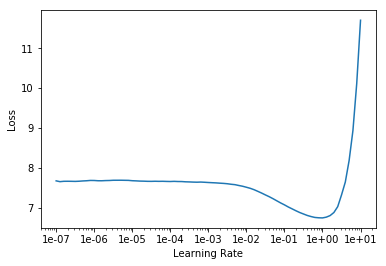

In [0]:
# plot learning rate performance to get max learning rate for one cycle fitting
lm_learn.recorder.plot()

In [0]:
# run one cycle training with max learning rate equal to ~1/10 (1 order of magnitude) of min learning rate in plot

# Run one epoch with lower layers 
lm_learn.fit_one_cycle(cyc_len=1, max_lr=1e-1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.227602,3.915131,0.353919,03:02


In [0]:
# Run for many epochs with all layers unfrozen and reduce max learning rate by factor of 2.6 (according to paper)
lm_learn.unfreeze()
lm_learn.fit_one_cycle(cyc_len=2, max_lr=4e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.669364,3.536196,0.397200,03:41
1,3.461298,3.422995,0.411415,03:41


In [0]:
# save the fine tuned encoder
lm_learn.save_encoder('ft_sentiment_enc')

#### Train Target Task Classification

Now we use our fine tuned encoder (Generalized Language Model) and train our classification task on top of this. The fast.ai library provides the [text_classification_learner](https://docs.fast.ai/text.learner.html#text_classifier_learner) function that allows us to easily build this model and load our fine tuned encoder into it.



In [0]:
# instantiate classifcation task learner
cla_learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)

# load finetuned encoder and freeze layers
cla_learn.load_encoder('ft_sentiment_enc')
cla_learn.freeze()

In [0]:
# find max learning rate for one cycle training
cla_learn.lr_find(start_lr=1e-8, end_lr=1e2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


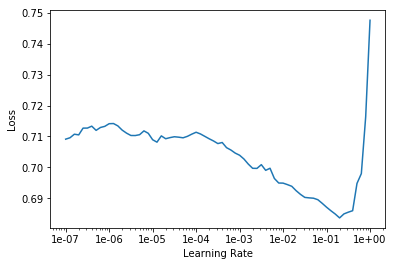

In [0]:
cla_learn.recorder.plot()

In [0]:
# run one cycle training with max learning rate equal to 1/10 of min learning rate in plot

# train final layer for 1 epoch
cla_learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.622280,0.598938,0.658864,01:13


In [0]:
# gradual unfreeze to train model
cla_learn.freeze_to(-2)
cla_learn.fit_one_cycle(5, max_lr=1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.596262,0.578558,0.679488,01:27
1,0.569617,0.541280,0.710581,01:25
2,0.543896,0.514847,0.731412,01:28
3,0.526032,0.504379,0.742188,01:30
4,0.523016,0.502911,0.742755,01:27
